In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt

import sys

sys.path.append(str(Path(".").resolve().parent))
from utils.perspective_api import unpack_scores

In [2]:
base_dir = Path("../data/jigsaw/multilingual/minimal/bleu_subset/nllb600/").resolve()
files = list(base_dir.glob("**/*_perspective.jsonl"))

base_english = pd.read_json(base_dir.parent / "en_toxic_perspective.jsonl", lines=True)

In [3]:
results = pd.DataFrame(
    {
        "toxicity": base_english["response"].apply(
            lambda x: unpack_scores(x)[0].get("toxicity") if x else None
        ),
        "language": "en",
        "direction": "base",
        "toxicity_set": "toxic",
    }
)

for f in files:
    df = pd.read_json(f, lines=True)
    language = f.name.split("_")[0] if "eng" not in f.name else f.name.split("_")[2]
    toxicity = {
        "toxicity": df["response"].apply(
            lambda x: unpack_scores(x)[0].get("toxicity") if x else None
        ),
        "language": language,
        "direction": "backtranslation" if "eng" in f.name else "from english",
        "toxicity_set": "nontoxic" if "nontoxic" in f.name else "toxic",
    }
    results = pd.concat([results, pd.DataFrame(toxicity)])
results = results.reset_index(drop=True)

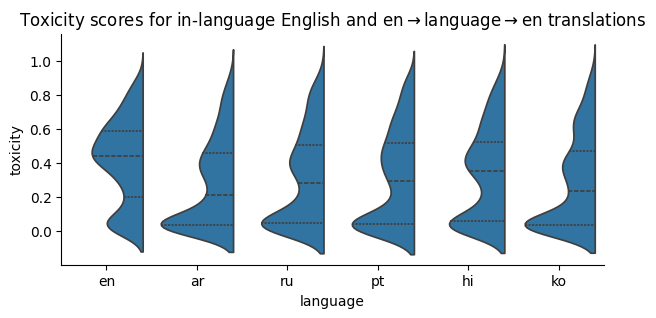

In [7]:
temp = results[results["direction"].isin(["base", "backtranslation"])].query(
    "toxicity_set == 'toxic'"
)
plt.figure(figsize=(7, 3))
sns.violinplot(
    data=temp, x="language", y="toxicity", fill=True, inner="quart", split=True
)
sns.despine(top=True, right=True)
plt.title(
    r"Toxicity scores for in-language English and en$\rightarrow$language$\rightarrow$en translations"
)
plt.savefig("../images/back_and_fwd_en_toxicity_translation.pdf", bbox_inches="tight")
plt.savefig("../images/back_and_fwd_en_toxicity_translation.svg", bbox_inches="tight")
plt.show()

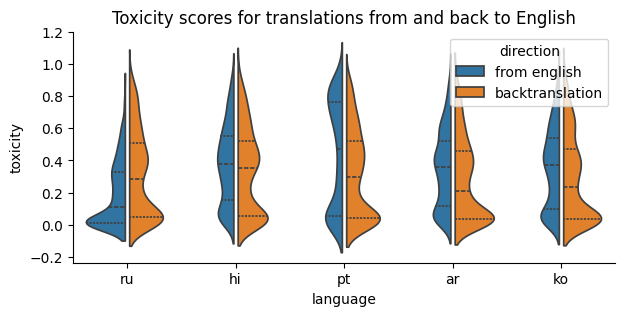

In [8]:
temp = results.query("direction in ['from english', 'backtranslation']").query(
    "toxicity_set == 'toxic'"
)
plt.figure(figsize=(7, 3))
sns.violinplot(
    data=temp,
    x="language",
    y="toxicity",
    hue="direction",
    split=True,
    gap=0.1,
    inner="quart",
)
plt.title("Toxicity scores for translations from and back to English")
sns.despine(top=True, right=True)
plt.savefig("../images/from_and_to_eng_toxicity_translation.pdf", bbox_inches="tight")
plt.savefig("../images/from_and_to_eng_toxicity_translation.svg", bbox_inches="tight")
plt.show()

/var/tmp/ipykernel_19170/1306170956.py:17: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.violinplot(


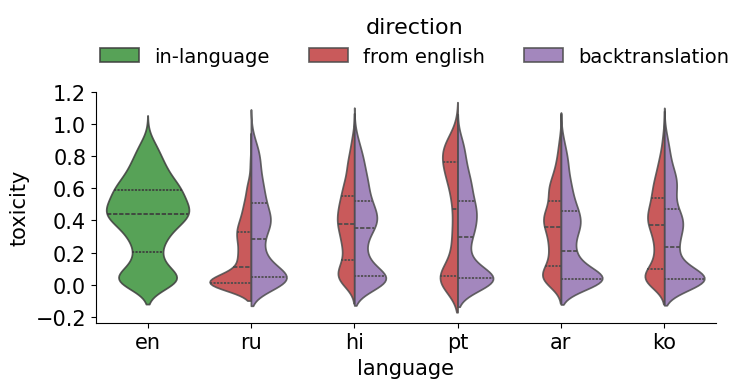

In [29]:
temp = results.query("direction in ['from english', 'backtranslation']").query(
    "toxicity_set == 'toxic'"
)
plt.figure(figsize=(8, 3))
sns.violinplot(
    data=results.query("direction == 'base'"),
    x="language",
    y="toxicity",
    fill=True,
    inner="quart",
    color="tab:green",
    label="in-language",
    alpha=0.85,
)

palette = sns.color_palette("tab10")[3:]
sns.violinplot(
    data=temp,
    x="language",
    y="toxicity",
    hue="direction",
    split=True,
    inner="quart",
    palette=palette,
    alpha=0.85,
)
plt.legend(
    title_fontsize=16,
    fontsize=14,
    title="direction",
    ncols=3,
    frameon=False,
    bbox_to_anchor=(1.05, 1.4),
)

sns.despine(top=True, right=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("language", fontsize=15)
plt.ylabel("toxicity", fontsize=15)
# plt.title("Toxicity scores for translations from and back to English")
plt.savefig(
    "../images/from_and_to_eng_toxicity_translation_complete.pdf", bbox_inches="tight"
)
plt.savefig(
    "../images/from_and_to_eng_toxicity_translation_complete.svg", bbox_inches="tight"
)
plt.show()

## Compared to native

In [38]:
translated_results = results.copy()

In [39]:
base_dir = Path("../data/jigsaw/multilingual/domains").resolve()
files = list(base_dir.glob("**/*_perspective.jsonl"))

In [40]:
results = pd.DataFrame()

for f in files:
    df = pd.read_json(f, lines=True)
    language = f.name.split("_")[1]
    toxicity = {
        "toxicity": df["response"].apply(
            lambda x: unpack_scores(x)[0].get("toxicity") if x else None
        ),
        "language": language,
        "direction": "native",
        "toxicity_set": "nontoxic" if "nontoxic" in f.name else "toxic",
    }
    results = pd.concat([results, pd.DataFrame(toxicity)])
results = results.reset_index(drop=True)

In [50]:
translated_results.query("language == 'pt' and direction == 'from english'")

,toxicity,language,direction,toxicity_set
1000,0.024271,pt,from english,nontoxic
1001,0.015703,pt,from english,nontoxic
1002,0.000000,pt,from english,nontoxic
1003,0.000000,pt,from english,nontoxic
1004,0.000000,pt,from english,nontoxic
...,...,...,...,...
4995,0.542387,pt,from english,toxic
4996,0.078212,pt,from english,toxic
4997,0.280041,pt,from english,toxic
4998,0.822362,pt,from english,toxic


Text(0.5, 1.0, 'toxic datasets')

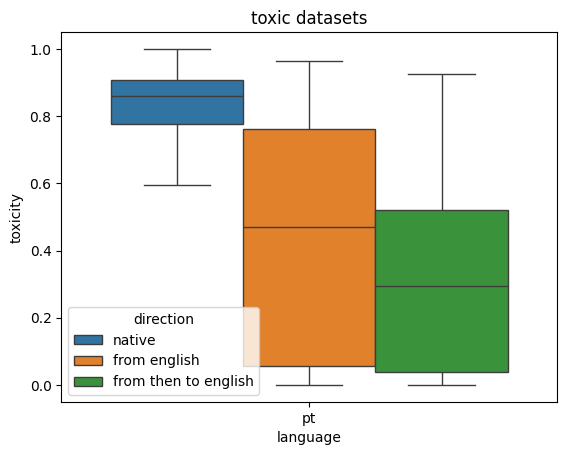

In [54]:
temp = results.query("toxicity_set == 'toxic'").sample(n=1000, replace=False).copy()
temp = pd.concat(
    [temp, translated_results.query("language == 'pt' and toxicity_set == 'toxic'")]
).reset_index(drop=True)

sns.boxplot(data=temp, x="language", y="toxicity", hue="direction", showfliers=False)
plt.title("toxic datasets")

Text(0.5, 1.0, 'nontoxic datasets')

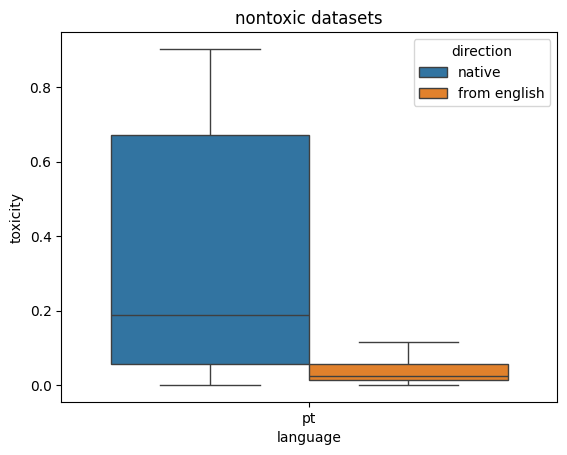

In [55]:
temp = results.query("toxicity_set == 'nontoxic'").sample(n=1000, replace=False).copy()
temp = pd.concat(
    [temp, translated_results.query("language == 'pt' and toxicity_set == 'nontoxic'")]
).reset_index()

sns.boxplot(data=temp, x="language", y="toxicity", hue="direction", showfliers=False)
plt.title("nontoxic datasets")